# Progetto IDS
### Nicolò Calandra - Andrea Di Blasi

## Obiettivo Analitico
L'obiettivo è di analizzare la correlazione tra posizione in qualifica, forma fisica del pilota e posizione in gara in base al tipo di circuito, che suddivideremo in 3 categorie: circuito ad alta velocità, circuito tecnico e circuito misto.
Con circuito tecnico intendiamo una pista ricca di curve, in cui il fattore più importante è la tecnica e bravura del pilota più che il veicolo che guida. Un circuito ad alta velocità, invece, è costituito da più rettilinei in cui la tecnica e la bravura del pilota sono meno influenti sul risultato della gara, bensì la potenza del veicolo influenza la posizione finale. Un circuito misto è costituito da una combinazione di entrambe le caratteristiche.

## Caratteristiche del dataset
Come dataset utilizziamo F1DB, che contiene una grande quantità di dati dal 1950 al 2024, in particolare usiamo:
- La tabella circuiti, che contiene le informazioni riguardanti tutte le piste
- La tabella race results, che contiene le informazioni riguardanti i risultati delle gare
- La tabella races, che contiene le informazioni riguardanti alle gare

Per poi la creazione del modello di regressione logistica abbiamo utilizzato anche la tabella driver standings per poter ottenere la classifica generale ad ogni gara.


## Imports

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

## Caricamento dati

In [28]:
circuits = pd.read_csv("f1db-csv/f1db-circuits.csv")
races = pd.read_csv("f1db-csv/f1db-races.csv")
results = pd.read_csv("f1db-csv/f1db-races-race-results.csv")

driver_standings = pd.read_csv("f1db-csv/f1db-races-driver-standings.csv")


/var/folders/4h/1sww1ntx4bd__02c69f9yqjc0000gn/T/ipykernel_12152/3474851688.py:3: DtypeWarning: Columns (31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  results = pd.read_csv("f1db-csv/f1db-races-race-results.csv")


## Visualizzazione dati
Visualizziamo i dataset caricati per capire meglio le informazioni contenute.

In [29]:
circuits.head()

,id,name,fullName,previousNames,type,direction,placeName,countryId,latitude,longitude,length,turns,totalRacesHeld,circuitType
0,adelaide,Adelaide,Adelaide Street Circuit,NaN,STREET,CLOCKWISE,Adelaide,australia,-34.927222,138.617222,3.780,16,11,Tecnico
1,aida,Aida,Okayama International Circuit,TI Circuit Aida,RACE,CLOCKWISE,Aida,japan,34.915000,134.221111,3.703,13,2,Tecnico
2,ain-diab,Ain-Diab,Ain-Diab Circuit,NaN,ROAD,CLOCKWISE,Casablanca,morocco,33.578611,-7.687500,7.618,18,1,Misto
3,aintree,Aintree,Aintree Motor Racing Circuit,NaN,ROAD,CLOCKWISE,Aintree,united-kingdom,53.476944,-2.940556,4.828,8,5,Misto
4,anderstorp,Anderstorp Raceway,Anderstorp Raceway,Scandinavian Raceway,RACE,CLOCKWISE,Anderstorp,sweden,57.264167,13.601389,4.031,8,6,Tecnico


In [30]:
circuits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              77 non-null     object 
 1   name            77 non-null     object 
 2   fullName        77 non-null     object 
 3   previousNames   15 non-null     object 
 4   type            77 non-null     object 
 5   direction       77 non-null     object 
 6   placeName       77 non-null     object 
 7   countryId       77 non-null     object 
 8   latitude        77 non-null     float64
 9   longitude       77 non-null     float64
 10  length          77 non-null     float64
 11  turns           77 non-null     int64  
 12  totalRacesHeld  77 non-null     int64  
 13  circuitType     77 non-null     object 
dtypes: float64(3), int64(2), object(9)
memory usage: 8.5+ KB


In [31]:
races.head()

,id,year,round,date,time,grandPrixId,officialName,qualifyingFormat,sprintQualifyingFormat,circuitId,...,qualifying2Date,qualifying2Time,qualifyingDate,qualifyingTime,sprintQualifyingDate,sprintQualifyingTime,sprintRaceDate,sprintRaceTime,warmingUpDate,warmingUpTime
0,1,1950,1,1950-05-13,NaN,great-britain,1950 RAC British Grand Prix,TWO_SESSION,NaN,silverstone,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1950,2,1950-05-21,NaN,monaco,Grand Prix de Monaco 1950,TWO_SESSION,NaN,monaco,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1950,3,1950-05-30,NaN,indianapolis,1950 Indianapolis 500,FOUR_LAPS,NaN,indianapolis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1950,4,1950-06-04,NaN,switzerland,Grosser Preis der Schweiz 1950,TWO_SESSION,NaN,bremgarten,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1950,5,1950-06-18,NaN,belgium,1950 Belgian Grand Prix,TWO_SESSION,NaN,spa-francorchamps,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149 entries, 0 to 1148
Data columns (total 42 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               1149 non-null   int64  
 1   year                             1149 non-null   int64  
 2   round                            1149 non-null   int64  
 3   date                             1149 non-null   object 
 4   time                             48 non-null     object 
 5   grandPrixId                      1149 non-null   object 
 6   officialName                     1149 non-null   object 
 7   qualifyingFormat                 1149 non-null   object 
 8   sprintQualifyingFormat           18 non-null     object 
 9   circuitId                        1149 non-null   object 
 10  circuitType                      1149 non-null   object 
 11  direction                        1149 non-null   object 
 12  courseLength        

In [33]:
results.head()

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,polePosition,qualificationPositionNumber,qualificationPositionText,gridPositionNumber,gridPositionText,positionsGained,pitStops,fastestLap,driverOfTheDay,grandSlam
0,1,1950,1,1,1.0,1,2,nino-farina,alfa-romeo,alfa-romeo,...,True,1.0,1,1.0,1,0.0,NaN,True,NaN,False
1,1,1950,1,2,2.0,2,3,luigi-fagioli,alfa-romeo,alfa-romeo,...,False,2.0,2,2.0,2,0.0,NaN,False,NaN,False
2,1,1950,1,3,3.0,3,4,reg-parnell,alfa-romeo,alfa-romeo,...,False,4.0,4,4.0,4,1.0,NaN,False,NaN,False
3,1,1950,1,4,4.0,4,14,yves-giraud-cabantous,talbot-lago,talbot-lago,...,False,6.0,6,6.0,6,2.0,NaN,False,NaN,False
4,1,1950,1,5,5.0,5,15,louis-rosier,talbot-lago,talbot-lago,...,False,9.0,9,9.0,9,4.0,NaN,False,NaN,False


In [34]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26911 entries, 0 to 26910
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   raceId                       26911 non-null  int64  
 1   year                         26911 non-null  int64  
 2   round                        26911 non-null  int64  
 3   positionDisplayOrder         26911 non-null  int64  
 4   positionNumber               16096 non-null  float64
 5   positionText                 26911 non-null  object 
 6   driverNumber                 26911 non-null  int64  
 7   driverId                     26911 non-null  object 
 8   constructorId                26911 non-null  object 
 9   engineManufacturerId         26911 non-null  object 
 10  tyreManufacturerId           26911 non-null  object 
 11  sharedCar                    26911 non-null  bool   
 12  laps                         24991 non-null  float64
 13  time            

## Pulizia Dati

A questo punto dobbiamo creare un dataframe che contenga solamente le informazioni necessarie per la visualizzazione, ovvero:
- la posizione di partenza
- la posizione finale
- il tipo di circuito
- una categoria in base alla posizione finale:
    - Podio [1-3]
    - Punti [4-10] (i primi 10 piloti prendono punti)
    - No punti [11-22]


In [35]:
# Possiamo anche filtrare i dati per mantenere solo quelli più recenti
# races = races[races['year'] > 2000]
# results = results[results['year'] > 2000]

# Facciamo un merge tra i risultati e le gare
races.rename(columns={'id': 'raceId'}, inplace=True)
df = pd.merge(results, races, on='raceId', how='left', validate='m:1')  

# Facciamo un merge tra i risultati e i circuiti
circuits.rename(columns={'id': 'circuitId'}, inplace=True)
df = pd.merge(df, circuits, on='circuitId', how='left', validate='m:1')

# Selezioniamo solo le colonne che ci servono
df = df[['gridPositionNumber', 'positionNumber', 'circuitType_y']]

df.rename(columns={'circuitType_y': 'tipo_circuito'}, inplace=True)
df.rename(columns={'gridPositionNumber': 'posizione_partenza'}, inplace=True)
df.rename(columns={'positionNumber': 'posizione_finale'}, inplace=True)

# Selezioniamo solo le gare in cui il pilota parte da una delle prime due file
df = df[(df['posizione_partenza'] <= 4) & (df['posizione_partenza'] > 0)]
df = df[df['posizione_finale'] < 23]

# Creiamo una categoria per la posizione finale
df['punti'] = df['posizione_finale'].apply(lambda x: 'Non arrivato' if x == 0 else 'Podio' if x <= 3 else 'Punti' if x <= 10 else 'No punti')

# Eliminiamo le righe che contengono informazioni nulle
df = df.dropna()


df.head()


,posizione_partenza,posizione_finale,tipo_circuito,punti
0,1.0,1.0,Alta velocità,Podio
1,2.0,2.0,Alta velocità,Podio
2,4.0,3.0,Alta velocità,Podio
23,1.0,1.0,Tecnico,Podio
46,3.0,3.0,Alta velocità,Podio


## Visualizzazione Dati

#### Istogramma
Inizialmente visualizziamo i dati utilizzando degli istogrammi, che mostrano chiaramente le posizione dei piloti in base al tipo di circuito.

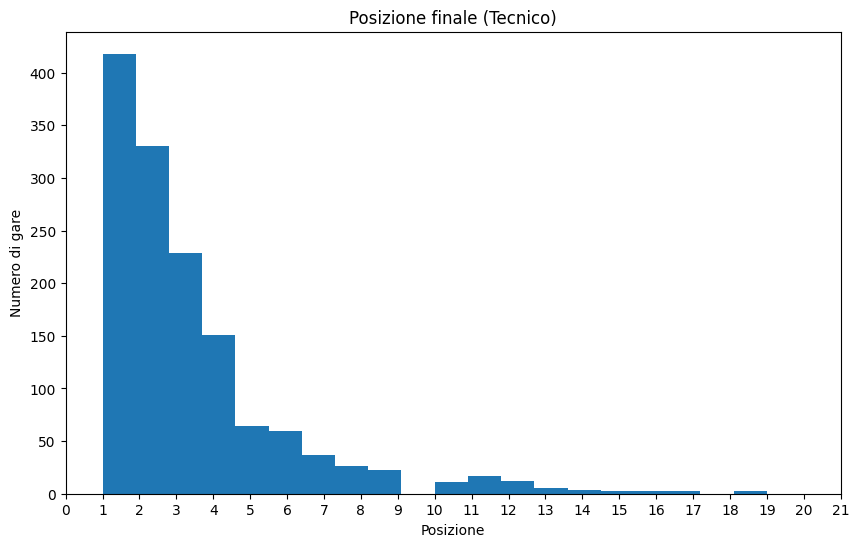

In [36]:
position_technical = df[df["tipo_circuito"] == "Tecnico"]
plt.figure(figsize=(10, 6))
plt.hist(position_technical["posizione_finale"].astype(int), bins=20)
plt.xlabel("Posizione") 
plt.ylabel("Numero di gare")
plt.title("Posizione finale (Tecnico)")
plt.xticks(range(0, 22))
plt.show()


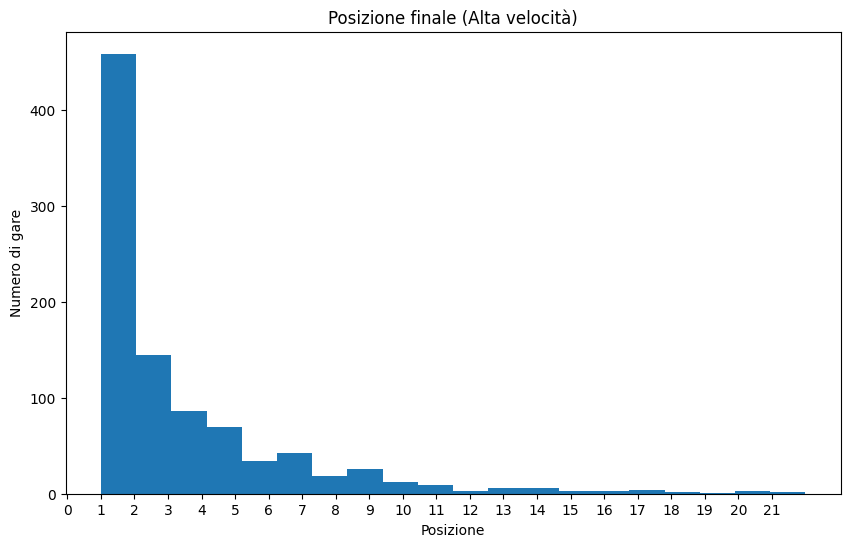

In [37]:
position_highspeed = df[df["tipo_circuito"] == "Alta velocità"]
plt.figure(figsize=(10, 6))
plt.hist(position_highspeed["posizione_finale"].astype(int), bins=20)
plt.xlabel("Posizione") 
plt.ylabel("Numero di gare")
plt.title("Posizione finale (Alta velocità)")
plt.xticks(range(0, 22))
plt.show()

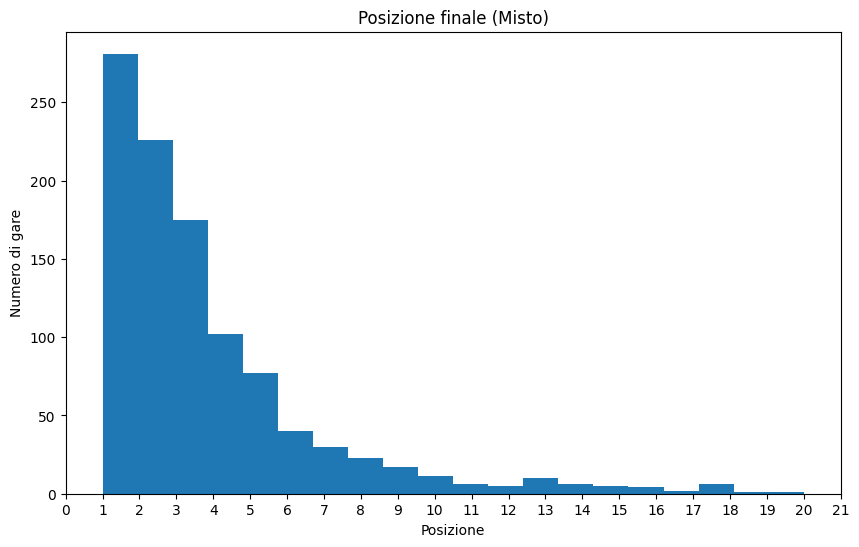

In [38]:
position_misto = df[df["tipo_circuito"] == "Misto"]
plt.figure(figsize=(10, 6))
plt.hist(position_misto["posizione_finale"].astype(int), bins=20)
plt.xlabel("Posizione") 
plt.ylabel("Numero di gare")
plt.xticks(range(0, 22))
plt.title("Posizione finale (Misto)")

plt.show()

Possiamo calcolare la posizione media per ogni tipo di circuito

In [39]:
# Calcoliamo la media per ogni tipo di circuito
tipo_circuito = ["Tecnico", "Alta velocità", "Misto"]
media = {}

for i in range(0, len(tipo_circuito)):
    print("----" + tipo_circuito[i] + "----")
    df_i = df[df['tipo_circuito'] == tipo_circuito[i]]
    media[i] = df_i['posizione_finale'].mean()
    print("Posizione media: " + str(media[i]) + "\n")

----Tecnico----
Posizione media: 3.206576125804146

----Alta velocità----
Posizione media: 3.6506410256410255

----Misto----
Posizione media: 3.509727626459144



#### Box-plot
Adesso visualizziamo i dati tramite dei boxplot per ogni tipo di circuito per evidenziare la mediana delle posizioni dei piloti in base al tipo di circuito

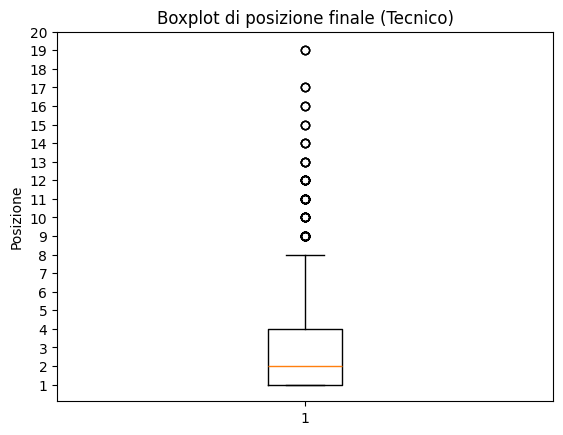

In [40]:
plt.boxplot(position_technical["posizione_finale"].astype(int))
plt.yticks(range(1, 21))
plt.ylabel("Posizione")
plt.title("Boxplot di posizione finale (Tecnico)")
plt.show()

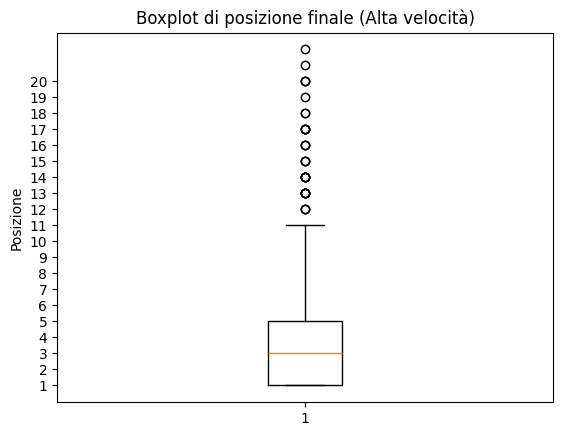

In [41]:
plt.boxplot(position_highspeed["posizione_finale"].astype(int))
plt.yticks(range(1, 21))
plt.ylabel("Posizione")
plt.title("Boxplot di posizione finale (Alta velocità)")
plt.show()

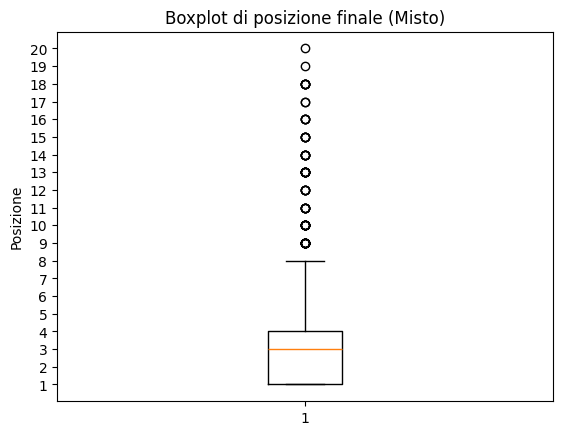

In [42]:
plt.boxplot(position_misto["posizione_finale"].astype(int))
plt.yticks(range(1, 21))
plt.ylabel("Posizione")
plt.title("Boxplot di posizione finale (Misto)")
plt.show()

Ora calcoliamo la mediana per tipo di circuito.

In [43]:
# Calcoliamo la mediana per ogni tipo di circuito
mediana = {}

for i in range(0, len(tipo_circuito)):
    print("----" + tipo_circuito[i] + "----")
    df_i = df[df['tipo_circuito'] == tipo_circuito[i]]
    mediana[i] = df_i['posizione_finale'].median()
    print("Posizione media: " + str(mediana[i]) + "\n")

----Tecnico----
Posizione media: 2.0

----Alta velocità----
Posizione media: 3.0

----Misto----
Posizione media: 3.0



Possiamo confrontare la media e mediana per trovare outlier che deviano in modo significativo la media.

In [44]:
for i in range(0, len(tipo_circuito)):
    print("----" + tipo_circuito[i] + "----")
    print("Media: " + str(media[i]) + "\n")
    print("Mediana: " + str(mediana[i]) + "\n")

----Tecnico----
Media: 3.206576125804146

Mediana: 2.0

----Alta velocità----
Media: 3.6506410256410255

Mediana: 3.0

----Misto----
Media: 3.509727626459144

Mediana: 3.0



Si può notare una grossa discrepanza tra la media e la mediana nella categoria "Tecnico". Questo mostra come ci siano tanti outliers in tale categoria.

## OLAP

Creiamo una OLAP per visualizzare in modo alternativo le informazioni dei piloti in base al tipo di circuito. Una volta creato l'OLAP possiamo fare slicing per poter osservare più chiaramente i dati.

In [45]:
placements = ["Podio", "Punti", "No punti"]
types = ["Tecnico", "Alta velocità", "Misto"]
grid = [1,2,3,4]

OLAP = np.zeros((4,3,3))
for z in range(0,len(types)):
  df_z = df[df['tipo_circuito'] == types[z]]
  for j in range(0,len(placements)):
    for i in range(0,len(grid)):
      OLAP[i,j,z] = np.sum((df_z['posizione_partenza'] == grid[i]) & (df_z['punti'] == placements[j]))

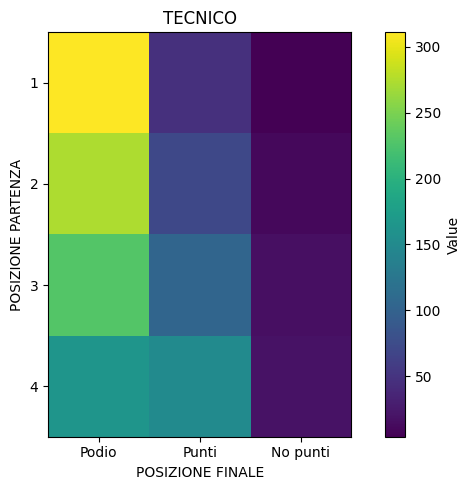

In [46]:
technical = OLAP[:,:,0]

plt.figure(figsize=(7,5))
plt.title('TECNICO')
plt.ylabel('POSIZIONE PARTENZA')
plt.yticks([0,1,2,3], ['1', '2', '3', '4'])
plt.xlabel('POSIZIONE FINALE')
plt.xticks([0,1,2], ['Podio', 'Punti', 'No punti'])
plt.imshow(technical)
plt.colorbar(label = "Value")

plt.tight_layout()
plt.show()


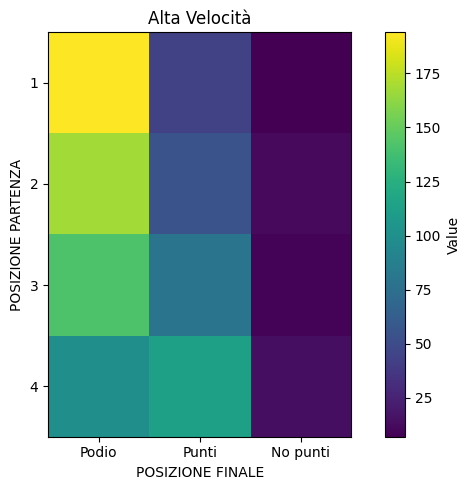

In [47]:
highspeed = OLAP[:,:,1]

plt.figure(figsize=(7,5))
plt.title('Alta Velocità')
plt.ylabel('POSIZIONE PARTENZA')
plt.yticks([0,1,2,3], ['1', '2', '3', '4'])
plt.xlabel('POSIZIONE FINALE')
plt.xticks([0,1,2], ['Podio', 'Punti', 'No punti'])
plt.imshow(highspeed)
plt.colorbar(label = "Value")

plt.tight_layout()
plt.show()


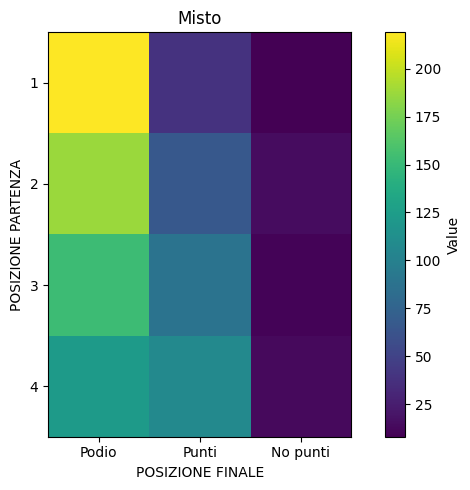

In [48]:
misto = OLAP[:,:,2]

plt.figure(figsize=(7,5))
plt.title('Misto')
plt.ylabel('POSIZIONE PARTENZA')
plt.yticks([0,1,2,3], ['1', '2', '3', '4'])
plt.xlabel('POSIZIONE FINALE')
plt.xticks([0,1,2], ['Podio', 'Punti', 'No punti'])
plt.imshow(misto)
plt.colorbar(label = "Value")

plt.tight_layout()
plt.show()

Possiamo anche calcolare una percentuale rispetto all'arrivo sul podio e alla posizione di partenza per tipo di circuito.

In [49]:
# Calcoliamo la percentuale di arrivi sul podio per ogni posizione di partenza in base anche al tipo di ciruito
for j in range(0, len(types)):
  print("----" + types[j] + "----")
  for i in range(0, len(grid)):
    df_i = df[(df['posizione_partenza'] == grid[i]) & (df['tipo_circuito'] == types[j])]
    df_i = df_i[df_i['punti'] == 'Podio']
    print("Posizione di partenza: " + str(grid[i]) + " - Percentuale di arrivi sul podio: " + str(int(len(df_i) / len(df[(df['posizione_partenza'] == grid[i]) & (df['tipo_circuito'] == types[j])]) * 100)) + "%")

----Tecnico----
Posizione di partenza: 1 - Percentuale di arrivi sul podio: 86%
Posizione di partenza: 2 - Percentuale di arrivi sul podio: 77%
Posizione di partenza: 3 - Percentuale di arrivi sul podio: 65%
Posizione di partenza: 4 - Percentuale di arrivi sul podio: 49%
----Alta velocità----
Posizione di partenza: 1 - Percentuale di arrivi sul podio: 79%
Posizione di partenza: 2 - Percentuale di arrivi sul podio: 71%
Posizione di partenza: 3 - Percentuale di arrivi sul podio: 61%
Posizione di partenza: 4 - Percentuale di arrivi sul podio: 44%
----Misto----
Posizione di partenza: 1 - Percentuale di arrivi sul podio: 82%
Posizione di partenza: 2 - Percentuale di arrivi sul podio: 69%
Posizione di partenza: 3 - Percentuale di arrivi sul podio: 60%
Posizione di partenza: 4 - Percentuale di arrivi sul podio: 50%


Notiamo come nei circuiti Tecnici la posizione di partenza influisca di più rispetto agli altri due tipi di circuiti

# Test statistici

Il test statistico che vogliamo condurre consiste nel verificare se la posizione finale media è inferiore per chi parte più avanti. Inoltre valutiamo anche se la differenza tra le posizioni finali tra i piloti che partono in posizione 1 e 2 è inferiore o maggiore rispetto a quella tra i piloti che partono in posizione 3 e 4. Questo ci fa capire se c'è più differenza nella prima linea rispetto alla seconda.

Ipotesi nulla: 
La posizione finale media è inferiore per chi parte più avanti.

Ipotesi alternativa: 
La posizione finale media è maggiore per chi parte più avanti.

Utilizziamo un t-test ad una coda con significatività 0.05.



In [50]:
# Test statistici

# Definiamo le coppie da confrontare (prime due linee)
comparison_pairs = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]

def pair_position_comparison(tipo_circuito):
    print(f"\n--- Tipo Circuito: {tipo_circuito} ---")
    df_circuito = df[df['tipo_circuito'] == tipo_circuito]

    # Itera sulle coppie di posizioni di partenza da confrontare
    for p_start1, p_start2 in comparison_pairs:
        print(f"\n  Confronto: P{p_start1} vs P{p_start2}")

        group1_pos_finale = df_circuito[df_circuito['posizione_partenza'] == p_start1]['posizione_finale'].dropna()
        group2_pos_finale = df_circuito[df_circuito['posizione_partenza'] == p_start2]['posizione_finale'].dropna()

        t_stat, p_value = stats.ttest_ind(
            group1_pos_finale,
            group2_pos_finale,
            equal_var=False,      
            alternative='less',    
        )

        print(f"    Media Pos. Finale P{p_start1}: {group1_pos_finale.mean():.2f} (N={len(group1_pos_finale)})")
        print(f"    Media Pos. Finale P{p_start2}: {group2_pos_finale.mean():.2f} (N={len(group2_pos_finale)})")
        print(f"    T-statistic:              {t_stat}")
        print(f"    P-value (one-tailed):     {p_value}")

        # Interpretazione del p-value
        if p_value < 0.05:
            print(f"    -> Differenza statisticamente significativa (p < 0.05).")
            print(f"       La posizione finale media per P{p_start1} è significativamente inferiore a quella per P{p_start2}.")
        else:
            print(f"    -> Differenza non statisticamente significativa (p >= 0.05).")

    medie_posizioni = {}

    # Calcoliamo le medie per ogni posizione di partenza
    for p_start in [1, 2, 3, 4]:
        pos_finale_group = df_circuito[df_circuito['posizione_partenza'] == p_start]['posizione_finale'].dropna()
        if len(pos_finale_group) > 0:
            medie_posizioni[p_start] = pos_finale_group.mean()
        else:
            medie_posizioni[p_start] = None 

    # --- Calcolo e confronto differenze tra file ---
    print(f"\n  Confronto Differenze Medie tra File (Tipo: {tipo_circuito}):")

    diff_fila1 = None
    if medie_posizioni.get(1) is not None and medie_posizioni.get(2) is not None:
        diff_fila1 = abs(medie_posizioni[1] - medie_posizioni[2])
        print(f"    Differenza Media Fila 1 (P1 vs P2): {diff_fila1:.2f} (Basata su medie {medie_posizioni[1]:.2f} e {medie_posizioni[2]:.2f})")
    else:
        print("    Differenza Media Fila 1 (P1 vs P2): Dati insufficienti.")

    diff_fila2 = None
    if medie_posizioni.get(3) is not None and medie_posizioni.get(4) is not None:
        diff_fila2 = abs(medie_posizioni[3] - medie_posizioni[4])
        print(f"    Differenza Media Fila 2 (P3 vs P4): {diff_fila2:.2f} (Basata su medie {medie_posizioni[3]:.2f} e {medie_posizioni[4]:.2f})")
    else:
        print("    Differenza Media Fila 2 (P3 vs P4): Dati insufficienti.")

    # Confronto descrittivo
    if diff_fila1 is not None and diff_fila2 is not None:
        if abs(diff_fila1 - diff_fila2) < 0.1: # Tolleranza piccola per definire "simili"
            print("    -> Le differenze medie tra le file sono molto simili.")
        elif diff_fila1 > diff_fila2:
            print("    -> La differenza media tra P1 e P2 è MAGGIORE di quella tra P3 e P4.")
        else:
            print("    -> La differenza media tra P3 e P4 è MAGGIORE di quella tra P1 e P2.")
    

Adesso utilizziamo la funzione per i tre tipi di circuito, che ricordiamo essere:
- Tecnico
- Alta velocità
- Misto

In [51]:
pair_position_comparison("Tecnico")


--- Tipo Circuito: Tecnico ---

  Confronto: P1 vs P2
    Media Pos. Finale P1: 2.07 (N=361)
    Media Pos. Finale P2: 2.89 (N=354)
    T-statistic:              -4.650591781436484
    P-value (one-tailed):     2.0023137362412415e-06
    -> Differenza statisticamente significativa (p < 0.05).
       La posizione finale media per P1 è significativamente inferiore a quella per P2.

  Confronto: P1 vs P3
    Media Pos. Finale P1: 2.07 (N=361)
    Media Pos. Finale P3: 3.67 (N=350)
    T-statistic:              -8.41510981783519
    P-value (one-tailed):     1.3941074037134828e-16
    -> Differenza statisticamente significativa (p < 0.05).
       La posizione finale media per P1 è significativamente inferiore a quella per P3.

  Confronto: P1 vs P4
    Media Pos. Finale P1: 2.07 (N=361)
    Media Pos. Finale P4: 4.29 (N=334)
    T-statistic:              -11.54806598127761
    P-value (one-tailed):     3.2152095768363353e-28
    -> Differenza statisticamente significativa (p < 0.05).
    

Osserviamo che la posizione media dei piloti che partono da una posizione di vantaggio è minore (ovvero hanno una posizione finale migliore). Inoltre la differenza di media tra le due file è minima, il che significa che non cambia la posizione finale se un pilota parte in una posizione più svantaggiosa ma nella stessa fila (per esempio se partisse secondo invece di primo).

Adesso analizziamo la categoria "Alta velocità"

In [52]:
pair_position_comparison("Alta velocità")


--- Tipo Circuito: Alta velocità ---

  Confronto: P1 vs P2
    Media Pos. Finale P1: 2.68 (N=244)
    Media Pos. Finale P2: 3.44 (N=235)
    T-statistic:              -2.5263316573933494
    P-value (one-tailed):     0.005934126821788221
    -> Differenza statisticamente significativa (p < 0.05).
       La posizione finale media per P1 è significativamente inferiore a quella per P2.

  Confronto: P1 vs P3
    Media Pos. Finale P1: 2.68 (N=244)
    Media Pos. Finale P3: 3.80 (N=230)
    T-statistic:              -4.10563295096811
    P-value (one-tailed):     2.378949779849483e-05
    -> Differenza statisticamente significativa (p < 0.05).
       La posizione finale media per P1 è significativamente inferiore a quella per P3.

  Confronto: P1 vs P4
    Media Pos. Finale P1: 2.68 (N=244)
    Media Pos. Finale P4: 4.76 (N=227)
    T-statistic:              -7.040985216754037
    P-value (one-tailed):     3.669022530051114e-12
    -> Differenza statisticamente significativa (p < 0.05).
 

Anche in questo caso la posizione media dei piloti che partono da una posizione di vantaggio è migliore e nuovamente la differenza tra file è minima.

In [53]:
pair_position_comparison("Misto")


--- Tipo Circuito: Misto ---

  Confronto: P1 vs P2
    Media Pos. Finale P1: 2.40 (N=266)
    Media Pos. Finale P2: 3.52 (N=268)
    T-statistic:              -4.281601220319757
    P-value (one-tailed):     1.1099371533781383e-05
    -> Differenza statisticamente significativa (p < 0.05).
       La posizione finale media per P1 è significativamente inferiore a quella per P2.

  Confronto: P1 vs P3
    Media Pos. Finale P1: 2.40 (N=266)
    Media Pos. Finale P3: 3.87 (N=251)
    T-statistic:              -5.70863354750041
    P-value (one-tailed):     9.900761189094769e-09
    -> Differenza statisticamente significativa (p < 0.05).
       La posizione finale media per P1 è significativamente inferiore a quella per P3.

  Confronto: P1 vs P4
    Media Pos. Finale P1: 2.40 (N=266)
    Media Pos. Finale P4: 4.34 (N=243)
    T-statistic:              -7.486775355976725
    P-value (one-tailed):     1.7280082426359047e-13
    -> Differenza statisticamente significativa (p < 0.05).
       

Anche nell'ultima categoria la posizione media è migliore per i piloti che partono da una posizione di vantaggio però la differenza nella stessa fila è significativa: la differenza di posizione media tra primo e secondo posto è di 1.12 mentre quella tra terzo e quarto posto è di 0.46. Questo ci fa capire che cambia tanto partire primo invece di secondo rispetto a partire terzo invece di quarto, nonostante entrambe le coppie partando dalla stessa fila.

# Regressione Logistica

Vogliamo creare un modello predittivo con l'algoritmo di regressione logistica che data la posizione di partenza, il tipo di circuito e il tempo del primo giro, possa prevedere se un pilota arrivi sul podio.

Per farlo, dobbiamo creare un dataframe che abbia: posizione di partenza, posizione in classifica del pilota pre-gara, tipo di circuito e posizione finale (Podio/No Podio).

In [54]:
# Uniamo races e circuits per ottenere il tipo di circuito per ogni gara
races_circuits = pd.merge(
                    races, 
                    circuits[['circuitId', 'circuitType']], 
                    on='circuitId', 
                    how='left', 
                    validate='m:m'
                )

# Uniamo standings con races per avere anno e round della classifica
driver_standings_info = pd.merge(
                            driver_standings[['raceId', 'driverId', 'points', 'positionDisplayOrder']],
                            races[['raceId', 'year', 'round']],
                            on='raceId', 
                            how='left', 
                            validate='m:m')

driver_standings_info = driver_standings_info.rename(columns={'positionDisplayOrder': 'classifica_post_gara'})

driver_standings_info['round_per_merge'] = driver_standings_info['round'] + 1
standings_per_merge = driver_standings_info[[
    'driverId', 'year', 'round_per_merge', 'classifica_post_gara'
]]


results_with_race_info = pd.merge(results[['raceId', 'driverId', 'constructorId', 'gridPositionNumber', 'positionNumber', 'points', 'laps']],
                                  races_circuits[['raceId', 'year', 'round', 'circuitType_y']],
                                  on='raceId', how='left', validate='m:1')

# Uniamo i risultati con le Classifiche pre-gara
final_df = pd.merge(
    results_with_race_info,
    standings_per_merge,
    left_on=['driverId', 'year', 'round'],
    right_on=['driverId', 'year', 'round_per_merge'],
    how='left',
    validate='m:m'
)

final_df = final_df.rename(columns={'classifica_post_gara': 'classifica_pre_gara'})

f1_analysis_df = final_df[final_df['round'] != 1].copy()
f1_analysis_df['podio'] = f1_analysis_df['positionNumber'].apply(lambda x: 1 if x < 4 else 0)

f1_analysis_df = f1_analysis_df[['gridPositionNumber', 'classifica_pre_gara', 'circuitType_y', 'podio']]
f1_analysis_df = f1_analysis_df.rename(columns={
    'gridPositionNumber': 'posizione_partenza',
    'classifica_pre_gara': 'classifica_pre_gara_rank',
    'circuitType_y': 'tipo_circuito',
})

f1_analysis_df = f1_analysis_df.dropna(subset=['posizione_partenza', 'podio', 'classifica_pre_gara_rank'])


f1_analysis_df['posizione_partenza'] = f1_analysis_df['posizione_partenza'].astype(int)
f1_analysis_df['classifica_pre_gara_rank'] = f1_analysis_df['classifica_pre_gara_rank'].astype(int)

#    Codifichiamo 'tipo_circuito' 
f1_analysis_df['tipo_circuito'] = np.where(
    f1_analysis_df['tipo_circuito'] == 'Tecnico', 0,
    np.where(f1_analysis_df['tipo_circuito'] == 'Alta velocità', 1, 2)
)
f1_analysis_df['tipo_circuito'] = f1_analysis_df['tipo_circuito'].astype(int)

# Visualizziamo il dataframe
f1_analysis_df.head()


,posizione_partenza,classifica_pre_gara_rank,tipo_circuito,podio
33,5,2,0,0
34,2,1,0,0
35,10,5,0,0
80,2,1,0,1
81,3,4,0,1


### Allenamento del modello
Ora che abbiamo creato il dataframe necessario per il modello di regressione lineare, dividiamo i dati in training e validation set utilizzando la funzione train_test_split.

In [55]:
feature = ["posizione_partenza", "classifica_pre_gara_rank", "tipo_circuito"]

# I dati in input sono posizione di partenza, tempo del primo giro e tipo di circuito
X = f1_analysis_df[feature]

# I dati in output sono la posizione finale
y = f1_analysis_df["podio"]

# Facciamo il train test split usando il 20% come test set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

Adesso che abbiamo preparato i dati dividendo il dataset in train e validation set possiamo allenare il modello.

In [56]:
model = LogisticRegression()

# Alleniamo sul dataset di training
model.fit(X_train, y_train)

# Facciamo le predizioni
y_pred = model.predict(X_valid)

### Correttezza
Verfichiamo adesso la correttezza del modello confrontando gli errori medi con quelli del modello null

In [57]:
print("------Modello LinearRegression------")
print("MAE:",metrics.mean_absolute_error(y_pred,y_valid))
print("MSE:",metrics.mean_squared_error(y_pred,y_valid))
print("RMSE:",metrics.root_mean_squared_error(y_pred,y_valid))

------Modello LinearRegression------
MAE: 0.1337295690936107
MSE: 0.1337295690936107
RMSE: 0.3656905373312395


In [58]:
# Calcoliamo lo score medio
mean_score = np.mean(y_train)
null_model_y = np.ones(len(y_valid)) * mean_score

print("------Null Model------")
print("MAE:",metrics.mean_absolute_error(null_model_y,y_valid))
print("MSE:",metrics.mean_squared_error(null_model_y,y_valid))
print("RMSE:",metrics.root_mean_squared_error(null_model_y,y_valid))

------Null Model------
MAE: 0.28217423810207864
MSE: 0.13915480811420558
RMSE: 0.3730345937231634


Possiamo notare come l'errore medio del nostro modello sia minore rispetto all'errore medio del modello nullo; questo indica che il nostro modello ha un buon livello di generalizzazione.

## Testing

Testiamo il nostro modello con la gara del 05/05/2025.
Ho preparato i dati in due file csv, che importiamo per poi far predirre il nostro modello:
- Gara contiene le informazioni da dare in input al modello per creare la predizione
    - posizione_partenza
    - classifica_pre_gara_rank (la posizione in classifica generale dopo la gara precedente)
    - tipo_circuito
- Risultati gara contiene le informazioni della gara finita da confrontare con l'output del modello

In [59]:
gara = pd.read_csv("f1db-csv/gara04-05-25.csv")
risultati_gara = pd.read_csv("f1db-csv/risultati-gara-04-05-25.csv")


gara.head()

,posizione_partenza,classifica_pre_gara_rank,tipo_circuito
0,1,3,2
1,2,2,2
2,3,6,2
3,4,1,2
4,5,7,2


In [60]:
prediction = model.predict(gara)

# Aggiungiamo la prediction al nostro dataset
gara['podio'] = prediction
gara['podio'] = gara['podio'].apply(lambda x: 'Si' if x == 1 else 'No')
gara['tipo_circuito'] = "Misto"

# Aggiungiamo al nostro dataset i veri risultati
gara['posizione_finale'] = risultati_gara['posizione_finale']
gara['nome'] = risultati_gara['nome']
gara


,posizione_partenza,classifica_pre_gara_rank,tipo_circuito,podio,posizione_finale,nome
0,1,3,Misto,Si,4,Verstappen
1,2,2,Misto,Si,2,Norris
2,3,6,Misto,No,6,Antonelli
3,4,1,Misto,Si,1,Piastri
4,5,7,Misto,No,3,Russell
5,6,16,Misto,No,9,Sainz
6,7,8,Misto,No,5,Albon
7,8,5,Misto,No,7,Leclerc
8,9,9,Misto,No,12,Ocon
9,10,11,Misto,No,10,Tsunoda
